In [64]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

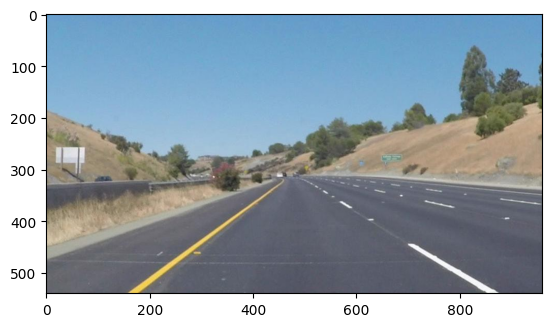

In [65]:
image = cv2.imread('Dataset/lane_detection_image.jpg')
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)

In [66]:
print(image.shape)

(540, 960, 3)


In [67]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

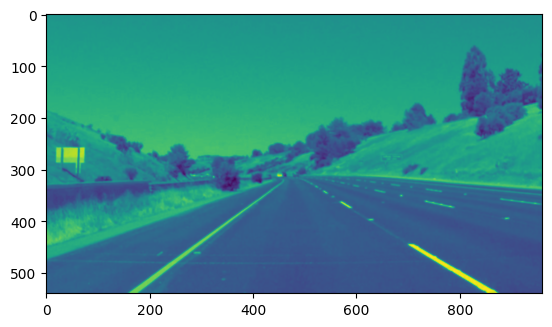

In [68]:
## Blurring Images
kernel_size = 5
blur_image = cv2.GaussianBlur(grayscale_image, (kernel_size, kernel_size), 0)
plt.imshow(blur_image)

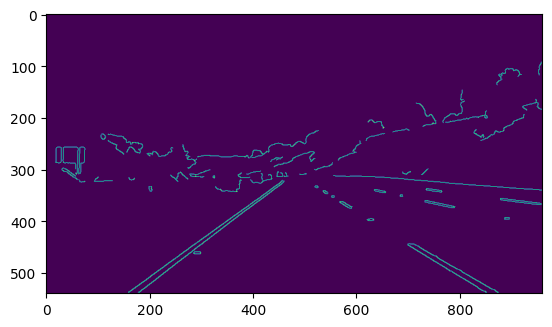

In [69]:
## Edge Detection using Canny edge detector
min_thres, max_thres = 100,200
edges = cv2.Canny(blur_image, min_thres, max_thres)
plt.imshow(edges)

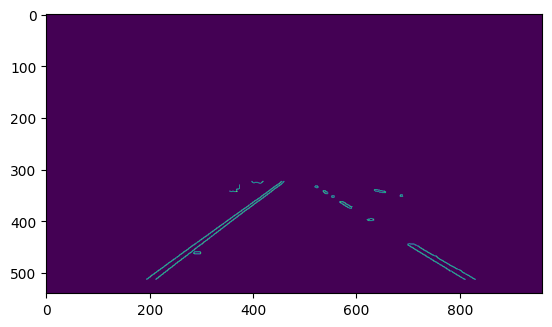

In [84]:
## Applying mask to get the region of interest

mask = np.zeros_like(grayscale_image)
# print(mask.shape)
if len(mask.shape) > 2:
    color_val = mask.shape[2]
    ignore_color_mask = (255, ) * color_val
else:
    ignore_color_mask = 255
# print(ignore_color_mask)
rows, cols = image.shape[:2]

bottom_left = [cols * 0.1, rows*0.95]
top_left = [cols * 0.4, rows * 0.6]
bottom_right = [cols * 0.95, rows * 0.95]
top_right = [cols * 0.7, rows * 0.6]

vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
# print(vertices)

## Fill white color for the mask
cv2.fillPoly(mask, vertices, ignore_color_mask)

## Apply the mask on the image to get cropped image
region_interest = cv2.bitwise_and(edges, mask)
plt.imshow(region_interest)

In [85]:
## FInd lines in the image using Probabilistic Hough Tranform
rho = 1
theta = np.pi/180
threshold = 20
minLineLength = 20
maxLineGap = 500

hough_lines = cv2.HoughLinesP(region_interest, rho=rho, theta=theta, threshold=threshold, minLineLength=minLineLength,maxLineGap=maxLineGap)
print(hough_lines)

[[[238 492 460 324]]

 [[195 513 454 325]]

 [[214 511 460 325]]

 [[522 335 831 513]]

 [[700 447 810 513]]

 [[520 335 829 513]]

 [[377 382 456 325]]

 [[194 513 365 389]]

 [[521 333 803 496]]

 [[538 346 702 445]]

 [[523 333 634 397]]

 [[637 340 689 350]]

 [[637 343 690 353]]]


In [86]:
## This function returns the average slope and intercept of left and right lanes
def averageSlopeIntercept(lines):
    
    leftLines = []
    leftLength = []
    rightLines = []
    rightLength = []
    
    for line in lines:
        for x1, y1, x2, y2, in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            
            if slope < 0:
                leftLines.append((slope, intercept))
                leftLength.append(length)
            else:
                rightLines.append((slope, intercept))
                rightLength.append(length)

    left_lane = np.dot(leftLength, leftLines) / np.sum(leftLength) if len(leftLength) > 0 else None
    right_lane = np.dot(rightLength, rightLines) / np.sum(rightLength) if len(rightLength) > 0 else None

    return left_lane, right_lane
# left, right = averageSlopeIntercept(hough_lines)
# print(left, '\n', right)

In [87]:
## This function returns pixel coordinates of a line given its slope and intercept values
def pixelCoordinates(y1, y2, line):
    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept) / (slope))
    x2 = int((y2 - intercept) / (slope))
    y1 = int(y1)
    y2 = int(y2)

    return((x1, y1), (x2, y2))

In [88]:
## Using the average slope and intercepts of left and right lanes, we find entire lines using
## the pixel values and the average slope, intercept values of the lines
def laneLinesOnImage(image, lines):
    left_lane, right_lane = averageSlopeIntercept(lines)

    ## The dimensions of image used are based on camera placement and region of interest
    ## In this case, it is the bottom have of the image or frames(if you consider the video) 
    y1 = image.shape[0]
    y2 = image.shape[0] * 0.5

    left_line = pixelCoordinates(y1, y2, left_lane)
    right_line = pixelCoordinates(y1, y2, right_lane)
    return left_line, right_line
left_line, right_line = laneLinesOnImage(image, hough_lines)
# print(left_line, '\n', right_line)

In [89]:
def DrawLines(image, lines, color=[255,0,0], thickness=10):
    line_mask = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_mask, *line, color, thickness)
    return cv2.addWeighted(image, 1.0, line_mask, 1.0, 0.0)

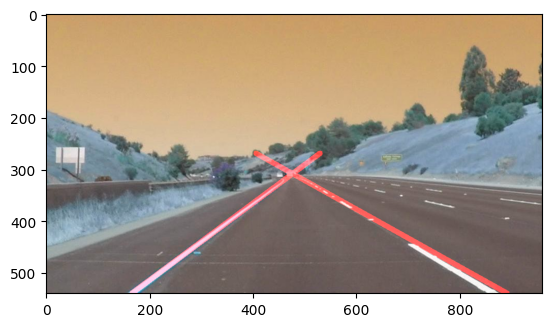

In [90]:
imageWithLines = DrawLines(image, laneLinesOnImage(image, hough_lines))
plt.imshow(imageWithLines)
